# 応用演習2<画像生成2>


---
　この演習では、少し詳しくGANsについて学びます。この演習資料は、2022年度応用演習5にて作成されたコードに説明を追加しました。GANsが、目的のデータ分布を学習していく工程を体験します。


---





> 前回の画像生成AIの演習にもあったようにGANsは識別器と生成器が競争しあって学習を進めていきます。では、実際にどのような順序で学習を進めていくのでしょうか。以下にGANsの全体の目的関数を示すます。

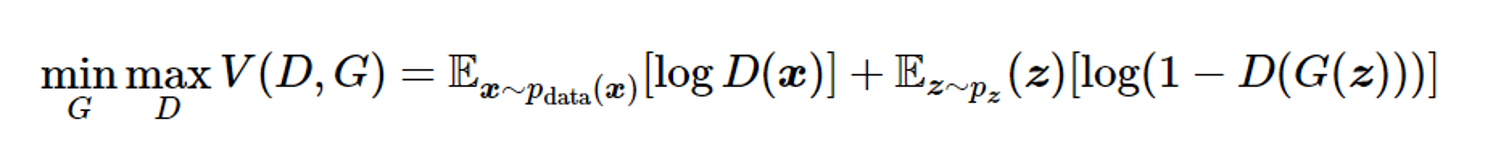








> ここで、*D*はDiscriminator(識別器)、*G*はGenerator(生成器)、*z*はノイズ、*x*は本物画像、*E*は期待値を表します。*z~Pz*は、*z*が、正規分布*Pz*からサンプリング(抽出)されたノイズであることを表しています。


> この数式は、Generatorが*V*を最小にし、Discriminatorが*V*を最大にするという訓練の目的を表しています。この数式を基づくと、DiscriminatorとGeneratorは、それぞれ次の解を目指します。


> Discriminator


*   *D(x)=1, D(G(z))=0*


> Generator


*   *D(G(z)) = 1*



> すなわち、Disciriminatorは、本物画像*x*はReal (*D(x)=1*)、*z*から*G*によって生成された画像*G(z)*は、Fake (*D(G(z))=0*)であるという判別を行います。一方、Generatorは、生成画像*G(z)*であっても、DiscriminatorがReal (*D(G(z)) = 1*）であると間違えるような画像を生成します。




> さらに、*z,x*がそれぞれ確率分布*Pz,Px*からサンプリングされたノイズと画像であるということを考えると、最終的に、*G*は、*Pz*を*Px*に近似させ、*D*を騙します。(GANsでは、モード(分布の最頻値)の周辺以外はペナルティが小さいため学習が難しく、モード崩壊と呼ばれる、モードだけをとらえた多様性のない画像が生成される場合があります。)















> それでは、GANsによって標準正規分布*Pz*が一様分布*Px*に近似されていく様子を確認します。



In [ ]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt



> GeneratorとDiscriminatorのネットワークを定義します。


*   線形層 ; nn.Linear(入力サイズ,出力サイズ)
*   活性化関数 : ReLU,LikeayReLU, Sigmoid()





In [ ]:
class Generator(nn.Module):
    def __init__(self,z_len):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_len, z_len*2),
            nn.ReLU(),
            nn.Linear(z_len*2,z_len*2),
            nn.ReLU(),
            nn.Linear(z_len*2,z_len),
            nn.Sigmoid()
            )
    def forward(self, z,):
        x = self.model(z)
        return x

class Discriminator(nn.Module):
    def __init__(self,z_len):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_len, z_len//2),
            nn.LeakyReLU(),
            nn.Linear(z_len//2, z_len//4),
            nn.LeakyReLU(),
            nn.Linear(z_len//4,1),
            nn.Sigmoid())

    def forward(self, z):
        x = self.model(z)
        return x



> 学習要件を定義します。



In [ ]:
batch_size = 1

num_epochs = 1000
#バイナリクロスエントロピー : ylogx + (1-y)log(1-x)
criterion = torch.nn.BCELoss()

#入力ノイズの次元数
z_len = 100

netG = Generator(z_len)

netD = Discriminator(z_len)

#本物のラベル
real_label = torch.ones(batch_size,1)
#偽物のラベル
fake_label = torch.zeros(batch_size,1)

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=[0.5, 0.999])



> 標準正規分布、一様分布、訓練されていな生成器が生成する分布を見てみましょう。標準正規分布(赤)と一様分布(青)は大きく離れています。当然、訓練前の生成器の出力(緑)は、一様分布(青)をとらえることができていません。



(array([ 1.64571249,  3.29142498,  5.76000785,  9.05141871, 18.10283741,
        13.16573222, 13.98855618, 12.34284369,  3.29142498,  1.64571249]),
 array([0.43716741, 0.4493202 , 0.46147299, 0.47362575, 0.48577854,
        0.49793133, 0.51008409, 0.52223688, 0.53438967, 0.54654247,
        0.55869526]),
 <BarContainer object of 10 artists>)

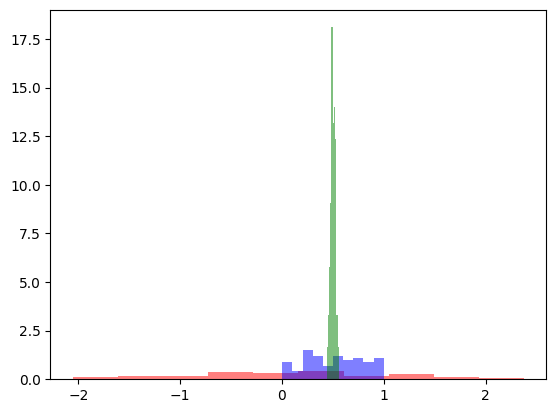

In [ ]:
Y_real = torch.rand(z_len,).detach().numpy()
z = torch.normal(0,1,size=(1,z_len))
z = torch.squeeze(z)
Y_fake = torch.squeeze(netG(z)).detach().numpy()
plt.figure()
plt.hist(z, density=True, alpha=0.5, color="r")
plt.hist(Y_real,density=True,alpha=0.5, color="b")
plt.hist(Y_fake,density=True,alpha=0.5, color="g")



> それでは、訓練を始めましょう。仕組みが分かっていれば非常にシンプルです。



In [ ]:
for epoch in range(num_epochs):
    #入力ノイズの分布(標準正規分布)に　#調べる
    z = torch.normal(0,1,size=(batch_size, z_len))
    #本物の分布（一様分布)に従う乱数生成
    x = torch.rand(batch_size, z_len)

    ######D######

    #output = D(x)
    output = netD(x)

    #D(x) → 1 ･･･(1)
    errD_real = criterion(output, real_label)
    #fake = G(z)
    fake = netG(z)
    #Gの固定
    fake_detach = fake.detach()
    #output = D(G(z))
    output = netD(fake_detach)
    #D(G(z)) → 0 ･･･ (2)
    errD_fake =   criterion(output, fake_label)

    #(1) + (2)
    errD = errD_real + errD_fake

    optimizerD.zero_grad()
    errD.backward()
    optimizerD.step()

    ######G######

    #output = D(G(z))
    output = netD(fake)
    #D(G(z)) → 1
    errG = criterion(output, real_label)

    optimizerG.zero_grad()
    errG.backward()
    optimizerG.step()

    if (epoch % 100 == 0):
        print('\t epoch {} \t errD_real {:.2f} \t errD_fake {:.2f} \t errG {:.2f}'
              .format(epoch, errD_real.item(), errD_fake.item(), errG.item()))

	 epoch 0 	 errD_real 0.71 	 errD_fake 0.68 	 errG 0.71
	 epoch 100 	 errD_real 0.70 	 errD_fake 0.70 	 errG 0.69
	 epoch 200 	 errD_real 0.67 	 errD_fake 0.69 	 errG 0.71
	 epoch 300 	 errD_real 0.66 	 errD_fake 0.71 	 errG 0.68
	 epoch 400 	 errD_real 0.68 	 errD_fake 0.67 	 errG 0.73
	 epoch 500 	 errD_real 0.74 	 errD_fake 0.65 	 errG 0.75
	 epoch 600 	 errD_real 0.70 	 errD_fake 0.69 	 errG 0.70
	 epoch 700 	 errD_real 0.63 	 errD_fake 0.75 	 errG 0.65
	 epoch 800 	 errD_real 0.69 	 errD_fake 0.68 	 errG 0.71
	 epoch 900 	 errD_real 0.71 	 errD_fake 0.69 	 errG 0.70




> 再び、それぞれの分布を表示します。GANsが一様分布(青)のモードをうまくとらえていることが分かりますね^v^


(array([2.53750372, 1.69166915, 0.52864661, 0.10572934, 0.52864653,
        0.84583471, 0.42291735, 0.52864636, 1.3744814 , 2.00885743]),
 array([0.02500521, 0.11958635, 0.21416749, 0.30874863, 0.40332976,
        0.49791092, 0.59249204, 0.68707317, 0.78165436, 0.87623549,
        0.97081661]),
 <BarContainer object of 10 artists>)

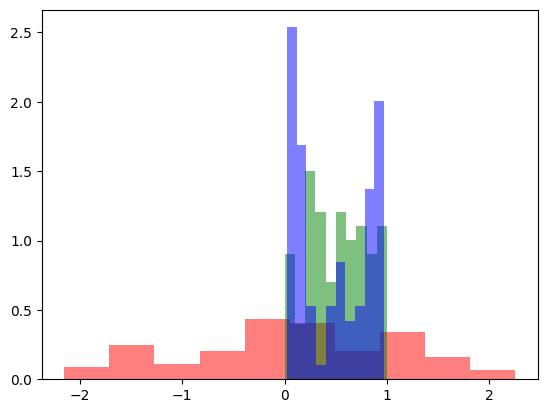

In [ ]:
netG.eval()
#z = torch.normal(0,1,size=(1,z_len))
#z = torch.squeeze(z)
#Y_real = torch.rand(z_len,).detach().numpy()
Y_fake = netG(torch.randn((z_len,)),).detach().numpy()
plt.figure()
plt.hist(z,density=True,alpha=0.5,color='r')
plt.hist(Y_real,density=True,alpha=0.5,color='g')
plt.hist(Y_fake,density=True,alpha=0.5,color='b')